In [1]:
# 1. Install Required Libraries

# !pip install yfinance pandas numpy scikit-learn tensorflow matplotlib seaborn plotly
# !pip install pycoingecko ccxt requests


In [2]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import warnings
import os
from datetime import datetime, timedelta
import time

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(1)
tf.random.set_seed(1)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


All libraries imported successfully!
TensorFlow version: 2.19.0


In [3]:
# 3. Configuration and Parameters
CONFIG = {
    'symbols': ['BTC-USD', 'ETH-USD', 'LTC-USD'],
    'crypto_names': ['Bitcoin', 'Ethereum', 'Litecoin'],
    'period': '2y',
    'interval': '1h',
    'outlier_threshold': 3,
    'forecast_horizons': [1, 4, 24],
    'train_size': 0.70,
    'val_size': 0.15,
    'test_size': 0.15,
    'sequence_length': 60,
    'lstm_units': 50,
    'lstm_layers': 2,
    'dropout_rate': 0.2,
    'batch_size': 64,
    'epochs': 50,
    'learning_rate': 0.001,
    'gru_units': 50,
    'gru_layers': 2,
    'gru_dropout_rate': 0.2,
    'gru_batch_size': 64,
    'gru_epochs': 50,
    'gru_learning_rate': 0.001,
}
print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"{key}: {value}")




Configuration loaded:
symbols: ['BTC-USD', 'ETH-USD', 'LTC-USD']
crypto_names: ['Bitcoin', 'Ethereum', 'Litecoin']
period: 2y
interval: 1h
outlier_threshold: 3
forecast_horizons: [1, 4, 24]
train_size: 0.7
val_size: 0.15
test_size: 0.15
sequence_length: 60
lstm_units: 50
lstm_layers: 2
dropout_rate: 0.2
batch_size: 64
epochs: 50
learning_rate: 0.001
gru_units: 50
gru_layers: 2
gru_dropout_rate: 0.2
gru_batch_size: 64
gru_epochs: 50
gru_learning_rate: 0.001


In [4]:
# 4. Collect Historical OHLCV Data
def collect_crypto_data(symbols, period='2y', interval='1h'):
    crypto_data = {}
    for symbol in symbols:
        try:
            print(f"Collecting data for {symbol}...")
            ticker = yf.Ticker(symbol)
            data = ticker.history(period=period, interval=interval)
            if data.empty:
                print(f"Warning: No data found for {symbol}")
                continue
            data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
            data['Symbol'] = symbol
            crypto_data[symbol] = data
            print(f"✓ {symbol}: {len(data)} records collected")
            print(f"  Date range: {data.index[0]} to {data.index[-1]}")
        except Exception as e:
            print(f"Error collecting data for {symbol}: {str(e)}")
    return crypto_data

print("Starting data collection...")
raw_data = collect_crypto_data(CONFIG['symbols'], CONFIG['period'], CONFIG['interval'])
print(f"\nData collection completed for {len(raw_data)} cryptocurrencies")


Starting data collection...
✓ BTC-USD: 17527 records collected
  Date range: 2023-11-10 00:00:00+00:00 to 2025-11-09 18:00:00+00:00
✓ ETH-USD: 17523 records collected
  Date range: 2023-11-10 00:00:00+00:00 to 2025-11-09 18:00:00+00:00
✓ LTC-USD: 17519 records collected
  Date range: 2023-11-10 00:00:00+00:00 to 2025-11-09 18:00:00+00:00

Data collection completed for 3 cryptocurrencies


In [5]:
# 5. Validate Data Integrity
def validate_data_integrity(crypto_data):
    print("Data Integrity Validation Report")
    print("=" * 50)
    for symbol, data in crypto_data.items():
        print(f"\n{symbol}:")
        print(f"  Shape: {data.shape}")
        print(f"  Date range: {data.index[0]} to {data.index[-1]}")
        print(f"  Missing values: {data.isnull().sum().sum()}")
        print(f"  Duplicated indices: {data.index.duplicated().sum()}")
        invalid_prices = (data[['Open', 'High', 'Low', 'Close']] <= 0).any(axis=1).sum()
        print(f"  Invalid prices (<=0): {invalid_prices}")
        print(f"  Price range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")
        print(f"  Average volume: {data['Volume'].mean():.0f}")

validate_data_integrity(raw_data)



Data Integrity Validation Report

BTC-USD:
  Shape: (17527, 6)
  Date range: 2023-11-10 00:00:00+00:00 to 2025-11-09 18:00:00+00:00
  Missing values: 0
  Duplicated indices: 0
  Invalid prices (<=0): 0
  Price range: $35264.38 - $126183.23
  Average volume: 480673282

ETH-USD:
  Shape: (17523, 6)
  Date range: 2023-11-10 00:00:00+00:00 to 2025-11-09 18:00:00+00:00
  Missing values: 0
  Duplicated indices: 0
  Invalid prices (<=0): 0
  Price range: $1415.84 - $4934.73
  Average volume: 300171279

LTC-USD:
  Shape: (17519, 6)
  Date range: 2023-11-10 00:00:00+00:00 to 2025-11-09 18:00:00+00:00
  Missing values: 0
  Duplicated indices: 0
  Invalid prices (<=0): 0
  Price range: $51.16 - $144.77
  Average volume: 7640735


In [6]:
# 6. Store Raw Data
os.makedirs('crypto_data', exist_ok=True)
for symbol, data in raw_data.items():
    filename = f"crypto_data/{symbol.replace('-', '_')}_raw.csv"
    data.to_csv(filename)
    print(f"Raw data saved: {filename}")

combined_data = pd.concat([data.assign(Crypto=symbol) for symbol, data in raw_data.items()], keys=raw_data.keys())
combined_data.to_csv('crypto_data/combined_raw_data.csv')
print("Combined raw data saved: crypto_data/combined_raw_data.csv")


Raw data saved: crypto_data/BTC_USD_raw.csv
Raw data saved: crypto_data/ETH_USD_raw.csv
Raw data saved: crypto_data/LTC_USD_raw.csv
Combined raw data saved: crypto_data/combined_raw_data.csv


In [7]:
# 7. Handle Missing Data
def handle_missing_data(data, method='forward_fill'):
    data_clean = data.copy()
    missing_before = data_clean.isnull().sum().sum()
    if method == 'forward_fill' or method == 'both':
        data_clean[['Open', 'High', 'Low', 'Close']] = data_clean[['Open', 'High', 'Low', 'Close']].fillna(method='ffill')
        data_clean['Volume'] = data_clean['Volume'].fillna(method='ffill')
    if method == 'linear_interpolation' or method == 'both':
        data_clean = data_clean.interpolate(method='linear')
    data_clean = data_clean.dropna()
    missing_after = data_clean.isnull().sum().sum()
    print(f"Missing values before: {missing_before}, after: {missing_after}")
    print(f"Rows before: {len(data)}, after: {len(data_clean)}")
    return data_clean

clean_data = {}
for symbol, data in raw_data.items():
    print(f"\nHandling missing data for {symbol}:")
    clean_data[symbol] = handle_missing_data(data, method='both')
print("\nMissing data handling completed for all cryptocurrencies.")




Handling missing data for BTC-USD:
Missing values before: 0, after: 0
Rows before: 17527, after: 17527

Handling missing data for ETH-USD:
Missing values before: 0, after: 0
Rows before: 17523, after: 17523

Handling missing data for LTC-USD:
Missing values before: 0, after: 0
Rows before: 17519, after: 17519

Missing data handling completed for all cryptocurrencies.


In [8]:
# 8. Detect and Remove Outliers
def detect_and_remove_outliers(data, threshold=3, columns=None):
    if columns is None:
        columns = ['Open', 'High', 'Low', 'Close']
    data_clean = data.copy()
    rows_before = len(data_clean)
    z_scores = np.abs((data_clean[columns] - data_clean[columns].mean()) / data_clean[columns].std())
    outlier_mask = (z_scores > threshold).any(axis=1)
    outliers_count = outlier_mask.sum()
    data_clean = data_clean[~outlier_mask]
    rows_after = len(data_clean)
    print(f"Outliers detected: {outliers_count} ({outliers_count/rows_before*100:.2f}%)")
    print(f"Rows removed: {rows_before - rows_after}")
    print(f"Remaining rows: {rows_after}")
    return data_clean

processed_data = {}
for symbol, data in clean_data.items():
    print(f"\nRemoving outliers for {symbol}:")
    processed_data[symbol] = detect_and_remove_outliers(data, threshold=CONFIG['outlier_threshold'])
print("\nOutlier removal completed for all cryptocurrencies.")



Removing outliers for BTC-USD:
Outliers detected: 0 (0.00%)
Rows removed: 0
Remaining rows: 17527

Removing outliers for ETH-USD:
Outliers detected: 0 (0.00%)
Rows removed: 0
Remaining rows: 17523

Removing outliers for LTC-USD:
Outliers detected: 1 (0.01%)
Rows removed: 1
Remaining rows: 17518

Outlier removal completed for all cryptocurrencies.


In [9]:
# 9. Resample Data for Forecast Horizons
def resample_data(data, freq):
    agg_rules = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }
    resampled = data.resample(freq).agg(agg_rules)
    resampled = resampled.dropna()
    return resampled

resampled_data = {}
horizon_mapping = {1: '1H', 4: '4H', 24: '1D'}
for horizon in CONFIG['forecast_horizons']:
    freq = horizon_mapping[horizon]
    resampled_data[horizon] = {}
    print(f"\nResampling data for {horizon}-hour horizon ({freq}):")
    for symbol, data in processed_data.items():
        if horizon == 1:
            resampled_data[horizon][symbol] = data.copy()
        else:
            resampled_data[horizon][symbol] = resample_data(data, freq)
        print(f"  {symbol}: {len(resampled_data[horizon][symbol])} records")
print("\nData resampling completed for all horizons.")




Resampling data for 1-hour horizon (1H):
  BTC-USD: 17527 records
  ETH-USD: 17523 records
  LTC-USD: 17518 records

Resampling data for 4-hour horizon (4H):
  BTC-USD: 4383 records
  ETH-USD: 4383 records
  LTC-USD: 4382 records

Resampling data for 24-hour horizon (1D):
  BTC-USD: 731 records
  ETH-USD: 731 records
  LTC-USD: 731 records

Data resampling completed for all horizons.


In [10]:
# 10. Normalize Data
def normalize_data(data, scaler_type='minmax'):
    if scaler_type == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("scaler_type must be 'minmax' or 'standard'")
    data_scaled = data.copy()
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data_scaled[feature_columns] = scaler.fit_transform(data[feature_columns])
    return data_scaled, scaler

normalized_data = {}
scalers = {}
for horizon in CONFIG['forecast_horizons']:
    normalized_data[horizon] = {}
    scalers[horizon] = {}
    print(f"\nNormalizing data for {horizon}-hour horizon:")
    for symbol, data in resampled_data[horizon].items():
        norm_data, scaler = normalize_data(data, 'minmax')
        normalized_data[horizon][symbol] = norm_data
        scalers[horizon][symbol] = scaler
        print(f"  {symbol}: Normalized {len(norm_data)} records")
        print(f"  Close price range: [{norm_data['Close'].min():.3f}, {norm_data['Close'].max():.3f}]")
print("\nData normalization completed for all horizons and cryptocurrencies.")




Normalizing data for 1-hour horizon:
  BTC-USD: Normalized 17527 records
  Close price range: [0.000, 1.000]
  ETH-USD: Normalized 17523 records
  Close price range: [0.000, 1.000]
  LTC-USD: Normalized 17518 records
  Close price range: [0.000, 1.000]

Normalizing data for 4-hour horizon:
  BTC-USD: Normalized 4383 records
  Close price range: [0.000, 1.000]
  ETH-USD: Normalized 4383 records
  Close price range: [0.000, 1.000]
  LTC-USD: Normalized 4382 records
  Close price range: [0.000, 1.000]

Normalizing data for 24-hour horizon:
  BTC-USD: Normalized 731 records
  Close price range: [0.000, 1.000]
  ETH-USD: Normalized 731 records
  Close price range: [0.000, 1.000]
  LTC-USD: Normalized 731 records
  Close price range: [0.000, 1.000]

Data normalization completed for all horizons and cryptocurrencies.


In [11]:
# 11. Feature Engineering for RNN
def create_rnn_features(data, sequence_length=60, target_column='Close'):
    data_with_time = data.copy()
    data_with_time['hour'] = data_with_time.index.hour / 23.0
    data_with_time['day_of_week'] = data_with_time.index.dayofweek / 6.0
    data_with_time['month'] = data_with_time.index.month / 11.0
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'hour', 'day_of_week', 'month']
    features = data_with_time[feature_columns].values
    X, y = [], []
    for i in range(sequence_length, len(features)):
        X.append(features[i-sequence_length:i])
        target_idx = feature_columns.index(target_column)
        y.append(features[i, target_idx])
    return np.array(X), np.array(y)

rnn_features = {}
for horizon in CONFIG['forecast_horizons']:
    rnn_features[horizon] = {}
    print(f"\nCreating RNN features for {horizon}-hour horizon:")
    for symbol, data in normalized_data[horizon].items():
        X, y = create_rnn_features(data, CONFIG['sequence_length'])
        rnn_features[horizon][symbol] = {'X': X, 'y': y}
        print(f"  {symbol}: X shape {X.shape}, y shape {y.shape}")
print("\nRNN feature engineering completed.")




Creating RNN features for 1-hour horizon:
  BTC-USD: X shape (17467, 60, 8), y shape (17467,)
  ETH-USD: X shape (17463, 60, 8), y shape (17463,)
  LTC-USD: X shape (17458, 60, 8), y shape (17458,)

Creating RNN features for 4-hour horizon:
  BTC-USD: X shape (4323, 60, 8), y shape (4323,)
  ETH-USD: X shape (4323, 60, 8), y shape (4323,)
  LTC-USD: X shape (4322, 60, 8), y shape (4322,)

Creating RNN features for 24-hour horizon:
  BTC-USD: X shape (671, 60, 8), y shape (671,)
  ETH-USD: X shape (671, 60, 8), y shape (671,)
  LTC-USD: X shape (671, 60, 8), y shape (671,)

RNN feature engineering completed.


In [12]:
# 12. Split Data Chronologically
def chronological_split(X, y, train_size=0.70, val_size=0.15, test_size=0.15):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Ratios must sum to 1"
    n_samples = len(X)
    train_end = int(n_samples * train_size)
    val_end = int(n_samples * (train_size + val_size))
    X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
    y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
    return X_train, X_val, X_test, y_train, y_val, y_test

rnn_splits = {}
print("RNN Data Splitting:")
print("="*40)
for horizon in CONFIG['forecast_horizons']:
    rnn_splits[horizon] = {}
    print(f"\n{horizon}-hour horizon:")
    for symbol in CONFIG['symbols']:
        X = rnn_features[horizon][symbol]['X']
        y = rnn_features[horizon][symbol]['y']
        X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(X, y, CONFIG['train_size'], CONFIG['val_size'], CONFIG['test_size'])
        rnn_splits[horizon][symbol] = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
                                       'y_train': y_train, 'y_val': y_val, 'y_test': y_test}
        print(f"  {symbol}: Train {X_train.shape[0]}, Val {X_val.shape[0]}, Test {X_test.shape[0]}")
print("\nData splitting completed.")


RNN Data Splitting:

1-hour horizon:
  BTC-USD: Train 12226, Val 2620, Test 2621
  ETH-USD: Train 12224, Val 2619, Test 2620
  LTC-USD: Train 12220, Val 2619, Test 2619

4-hour horizon:
  BTC-USD: Train 3026, Val 648, Test 649
  ETH-USD: Train 3026, Val 648, Test 649
  LTC-USD: Train 3025, Val 648, Test 649

24-hour horizon:
  BTC-USD: Train 469, Val 101, Test 101
  ETH-USD: Train 469, Val 101, Test 101
  LTC-USD: Train 469, Val 101, Test 101

Data splitting completed.


In [13]:
# 13. Define LSTM Model
def create_lstm_model(input_shape, units=50, layers=2, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=(layers>1), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    for i in range(1, layers):
        model.add(LSTM(units=units, return_sequences=(i<layers-1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model


In [14]:
# 14. Train LSTM Models
def train_lstm_model(X_train, y_train, X_val, y_val, config):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_lstm_model(input_shape, units=config['lstm_units'], layers=config['lstm_layers'],
                              dropout_rate=config['dropout_rate'], learning_rate=config['learning_rate'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    start_time = time.time()
    history = model.fit(X_train, y_train, batch_size=config['batch_size'], epochs=config['epochs'],
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    training_time = time.time() - start_time
    return model, history, training_time

lstm_models, lstm_histories, lstm_training_times = {}, {}, {}
print("Training LSTM Models:")
print("="*50)
for horizon in CONFIG['forecast_horizons']:
    lstm_models[horizon], lstm_histories[horizon], lstm_training_times[horizon] = {}, {}, {}
    print(f"\n{horizon}-hour horizon:")
    for symbol in CONFIG['symbols']:
        print(f"  Training {symbol}...", end=' ')
        splits = rnn_splits[horizon][symbol]
        model, history, training_time = train_lstm_model(splits['X_train'], splits['y_train'], splits['X_val'], splits['y_val'], CONFIG)
        lstm_models[horizon][symbol] = model
        lstm_histories[horizon][symbol] = history
        lstm_training_times[horizon][symbol] = training_time
        print(f"✓ {training_time:.1f}s, {len(history.history['loss'])} epochs, val_loss: {history.history['val_loss'][-1]:.6f}")
print("\nLSTM model training completed.")



Training LSTM Models:

1-hour horizon:
  Training BTC-USD... ✓ 72.2s, 32 epochs, val_loss: 0.000232
  Training ETH-USD... ✓ 96.3s, 50 epochs, val_loss: 0.000073
  Training LTC-USD... ✓ 104.0s, 50 epochs, val_loss: 0.000080

4-hour horizon:
  Training BTC-USD... ✓ 10.2s, 14 epochs, val_loss: 0.000485
  Training ETH-USD... ✓ 30.7s, 50 epochs, val_loss: 0.000322
  Training LTC-USD... ✓ 30.2s, 50 epochs, val_loss: 0.000438

24-hour horizon:
  Training BTC-USD... ✓ 10.1s, 39 epochs, val_loss: 0.003953
  Training ETH-USD... ✓ 6.2s, 19 epochs, val_loss: 0.004823
  Training LTC-USD... ✓ 11.5s, 50 epochs, val_loss: 0.003349

LSTM model training completed.


In [15]:
# 15. Define GRU Model
def create_gru_model(input_shape, units=50, layers=2, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=(layers>1), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    for i in range(1, layers):
        model.add(GRU(units=units, return_sequences=(i<layers-1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model



In [16]:
# 16. Train GRU Models
def train_gru_model(X_train, y_train, X_val, y_val, config):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_gru_model(input_shape, units=config['gru_units'], layers=config['gru_layers'],
                             dropout_rate=config['gru_dropout_rate'], learning_rate=config['gru_learning_rate'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    start_time = time.time()
    history = model.fit(X_train, y_train, batch_size=config['gru_batch_size'], epochs=config['gru_epochs'],
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    training_time = time.time() - start_time
    return model, history, training_time

gru_models, gru_histories, gru_training_times = {}, {}, {}
print("Training GRU Models:")
print("="*50)
for horizon in CONFIG['forecast_horizons']:
    gru_models[horizon], gru_histories[horizon], gru_training_times[horizon] = {}, {}, {}
    print(f"\n{horizon}-hour horizon:")
    for symbol in CONFIG['symbols']:
        print(f"  Training {symbol}...", end=' ')
        splits = rnn_splits[horizon][symbol]
        model, history, training_time = train_gru_model(splits['X_train'], splits['y_train'], splits['X_val'], splits['y_val'], CONFIG)
        gru_models[horizon][symbol] = model
        gru_histories[horizon][symbol] = history
        gru_training_times[horizon][symbol] = training_time
        print(f"✓ {training_time:.1f}s, {len(history.history['loss'])} epochs, val_loss: {history.history['val_loss'][-1]:.6f}")
print("\nGRU model training completed.")



Training GRU Models:

1-hour horizon:
  Training BTC-USD... ✓ 98.2s, 50 epochs, val_loss: 0.000293
  Training ETH-USD... ✓ 91.7s, 50 epochs, val_loss: 0.000080
  Training LTC-USD... ✓ 97.5s, 50 epochs, val_loss: 0.000067

4-hour horizon:
  Training BTC-USD... ✓ 11.3s, 15 epochs, val_loss: 0.000370
  Training ETH-USD... ✓ 30.1s, 50 epochs, val_loss: 0.000237
  Training LTC-USD... ✓ 30.2s, 50 epochs, val_loss: 0.000302

24-hour horizon:
  Training BTC-USD... ✓ 5.5s, 15 epochs, val_loss: 0.002191
  Training ETH-USD... ✓ 7.0s, 26 epochs, val_loss: 0.002452
  Training LTC-USD... ✓ 11.8s, 50 epochs, val_loss: 0.002173

GRU model training completed.


In [17]:
# 17. Evaluation Metrics Functions
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.inf
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

def denormalize_predictions(predictions, scaler, target_column_index=3):
    dummy_array = np.zeros((len(predictions), scaler.n_features_in_))
    dummy_array[:, target_column_index] = predictions.flatten()
    denorm = scaler.inverse_transform(dummy_array)
    return denorm[:, target_column_index]

print("Evaluation functions defined.")


Evaluation functions defined.


In [18]:
# 18. Evaluate LSTM Models
lstm_results = {}
print("Evaluating LSTM Models:")
print("="*60)
for horizon in CONFIG['forecast_horizons']:
    lstm_results[horizon] = {}
    print(f"\n{horizon}-hour horizon:")
    for symbol in CONFIG['symbols']:
        splits = rnn_splits[horizon][symbol]
        model = lstm_models[horizon][symbol]
        y_pred = model.predict(splits['X_test'], verbose=0)
        scaler = scalers[horizon][symbol]
        y_test_denorm = denormalize_predictions(splits['y_test'], scaler)
        y_pred_denorm = denormalize_predictions(y_pred, scaler)
        metrics = calculate_metrics(y_test_denorm, y_pred_denorm)
        lstm_results[horizon][symbol] = {
            'metrics': metrics,
            'y_test': y_test_denorm,
            'y_pred': y_pred_denorm,
            'training_time': lstm_training_times[horizon][symbol]
        }
        print(f"  {symbol}:")
        print(f"    MAE: {metrics['MAE']:.4f}")
        print(f"    RMSE: {metrics['RMSE']:.4f}")
        print(f"    MAPE: {metrics['MAPE']:.2f}%")
        print(f"    R²: {metrics['R2']:.4f}")
        print(f"    Training Time: {lstm_training_times[horizon][symbol]:.1f}s")
print("\nLSTM model evaluation completed.")




Evaluating LSTM Models:

1-hour horizon:
  BTC-USD:
    MAE: 1192.9966
    RMSE: 1437.7638
    MAPE: 1.04%
    R²: 0.9108
    Training Time: 72.2s
  ETH-USD:
    MAE: 31.5061
    RMSE: 42.6639
    MAPE: 0.76%
    R²: 0.9865
    Training Time: 96.3s
  LTC-USD:
    MAE: 0.6656
    RMSE: 1.1213
    MAPE: 0.62%
    R²: 0.9884
    Training Time: 104.0s

4-hour horizon:
  BTC-USD:
    MAE: 1768.1565
    RMSE: 2276.9046
    MAPE: 1.56%
    R²: 0.7754
    Training Time: 10.2s
  ETH-USD:
    MAE: 71.2642
    RMSE: 96.2491
    MAPE: 1.72%
    R²: 0.9305
    Training Time: 30.7s
  LTC-USD:
    MAE: 1.6660
    RMSE: 2.6153
    MAPE: 1.54%
    R²: 0.9371
    Training Time: 30.2s

24-hour horizon:
  BTC-USD:
    MAE: 3576.8670
    RMSE: 4438.7333
    MAPE: 3.14%
    R²: 0.1653
    Training Time: 10.1s


  ETH-USD:
    MAE: 238.8721
    RMSE: 296.0214
    MAPE: 5.87%
    R²: 0.3524
    Training Time: 6.2s
  LTC-USD:
    MAE: 4.4951
    RMSE: 6.3422
    MAPE: 4.23%
    R²: 0.6531
    Training Time: 11.5s

LSTM model evaluation completed.


In [19]:
# 19. Evaluate GRU Models
gru_results = {}
print("Evaluating GRU Models:")
print("="*60)
for horizon in CONFIG['forecast_horizons']:
    gru_results[horizon] = {}
    print(f"\n{horizon}-hour horizon:")
    for symbol in CONFIG['symbols']:
        splits = rnn_splits[horizon][symbol]
        model = gru_models[horizon][symbol]
        y_pred = model.predict(splits['X_test'], verbose=0)
        scaler = scalers[horizon][symbol]
        y_test_denorm = denormalize_predictions(splits['y_test'], scaler)
        y_pred_denorm = denormalize_predictions(y_pred, scaler)
        metrics = calculate_metrics(y_test_denorm, y_pred_denorm)
        gru_results[horizon][symbol] = {
            'metrics': metrics,
            'y_test': y_test_denorm,
            'y_pred': y_pred_denorm,
            'training_time': gru_training_times[horizon][symbol]
        }
        print(f"  {symbol}:")
        print(f"    MAE: {metrics['MAE']:.4f}")
        print(f"    RMSE: {metrics['RMSE']:.4f}")
        print(f"    MAPE: {metrics['MAPE']:.2f}%")
        print(f"    R²: {metrics['R2']:.4f}")
        print(f"    Training Time: {gru_training_times[horizon][symbol]:.1f}s")
print("\nGRU model evaluation completed.")

Evaluating GRU Models:

1-hour horizon:
  BTC-USD:
    MAE: 723.7942
    RMSE: 951.8922
    MAPE: 0.63%
    R²: 0.9609
    Training Time: 98.2s
  ETH-USD:
    MAE: 36.1229
    RMSE: 46.3057
    MAPE: 0.86%
    R²: 0.9842
    Training Time: 91.7s
  LTC-USD:
    MAE: 0.6810
    RMSE: 1.1025
    MAPE: 0.62%
    R²: 0.9888
    Training Time: 97.5s

4-hour horizon:
  BTC-USD:
    MAE: 1164.3384
    RMSE: 1516.2160
    MAPE: 1.02%
    R²: 0.9004
    Training Time: 11.3s
  ETH-USD:
    MAE: 70.7068
    RMSE: 92.7104
    MAPE: 1.69%
    R²: 0.9355
    Training Time: 30.1s
  LTC-USD:
    MAE: 1.4280
    RMSE: 2.2843
    MAPE: 1.31%
    R²: 0.9520
    Training Time: 30.2s

24-hour horizon:
  BTC-USD:
    MAE: 3389.0426
    RMSE: 4273.7679
    MAPE: 3.04%
    R²: 0.2262
    Training Time: 5.5s
  ETH-USD:
    MAE: 165.9464
    RMSE: 224.7416
    MAPE: 4.04%
    R²: 0.6268
    Training Time: 7.0s
  LTC-USD:
    MAE: 3.6013
    RMSE: 5.3460
    MAPE: 3.38%
    R²: 0.7535
    Training Time: 11.8s

GR

In [20]:
# 20. Visualizing Results
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def plot_predictions_subplots_interactive(lstm_results, gru_results, config, n_points=200):
    horizons = config['forecast_horizons']
    symbols = config['symbols']
    crypto_names = config['crypto_names']

    for horizon in horizons:
        fig = make_subplots(rows=1, cols=len(symbols),
                            subplot_titles=[f'{name.split()[0]} - {horizon}h Horizon' for name in crypto_names])
        for j, symbol in enumerate(symbols):
            lstm_data = lstm_results[horizon][symbol]
            gru_data = gru_results[horizon][symbol]
            actual = lstm_data['y_test']
            lstm_pred = lstm_data['y_pred']
            gru_pred = gru_data['y_pred']

            original_data_index = resampled_data[horizon][symbol].index
            test_index_start = len(original_data_index) - len(actual)
            historical_datetime_index = original_data_index[test_index_start:]

            if len(actual) > n_points:
                start_idx = len(actual) - n_points
                actual_plot = actual[start_idx:]
                lstm_pred_plot = lstm_pred[start_idx:]
                gru_pred_plot = gru_pred[start_idx:]
                historical_datetime_index_plot = historical_datetime_index[start_idx:]
            else:
                actual_plot = actual
                lstm_pred_plot = lstm_pred
                gru_pred_plot = gru_pred
                historical_datetime_index_plot = historical_datetime_index

            fig.add_trace(go.Scatter(x=historical_datetime_index_plot, y=actual_plot, mode='lines', name='Actual', line=dict(color='black', width=2)), row=1, col=j+1)
            fig.add_trace(go.Scatter(x=historical_datetime_index_plot, y=lstm_pred_plot, mode='lines', name='LSTM Prediction', line=dict(color='blue', width=1.5)), row=1, col=j+1)
            fig.add_trace(go.Scatter(x=historical_datetime_index_plot, y=gru_pred_plot, mode='lines', name='GRU Prediction', line=dict(color='red', width=1.5)), row=1, col=j+1)

            crypto_name = crypto_names[j].split()[0]
            ax_title = f'{crypto_name} - {horizon}h Horizon<br>(Last {len(actual_plot)} test points)'
            fig.update_xaxes(title_text='Date and Time', row=1, col=j+1)
            fig.update_yaxes(title_text='Price (USD)', row=1, col=j+1)
            fig.update_layout(title_text=ax_title)
            lstm_rmse = lstm_data['metrics']['RMSE']
            gru_rmse = gru_data['metrics']['RMSE']
            lstm_r2 = lstm_data['metrics']['R2']
            gru_r2 = gru_data['metrics']['R2']

            fig.add_annotation(
                x=historical_datetime_index_plot[int(len(historical_datetime_index_plot)*0.02)],
                y=max(actual_plot) * 0.98,
                xref=f'x{j+1}', yref=f'y{j+1}',
                text=f'LSTM RMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}',
                showarrow=False,
                font=dict(size=8, color='black'),
                bgcolor='lightblue',
                opacity=0.8
            )
            fig.add_annotation(
                x=historical_datetime_index_plot[int(len(historical_datetime_index_plot)*0.02)],
                y=max(actual_plot) * 0.88,
                xref=f'x{j+1}', yref=f'y{j+1}',
                text=f'GRU RMSE: {gru_rmse:.4f}, R²: {gru_r2:.4f}',
                showarrow=False,
                font=dict(size=8, color='black'),
                bgcolor='lightcoral',
                opacity=0.8
            )
        fig.update_layout(height=600, width=1800, title_text=f'Actual vs Predicted Price Comparison: LSTM vs GRU', showlegend=True)
        fig.show()

print("Creating Actual vs Predicted Price Plots (Interactive):")
plot_predictions_subplots_interactive(lstm_results, gru_results, CONFIG)
print("Prediction plots completed.")

Creating Actual vs Predicted Price Plots (Interactive):


Prediction plots completed.


Creating Performance Comparison Charts:


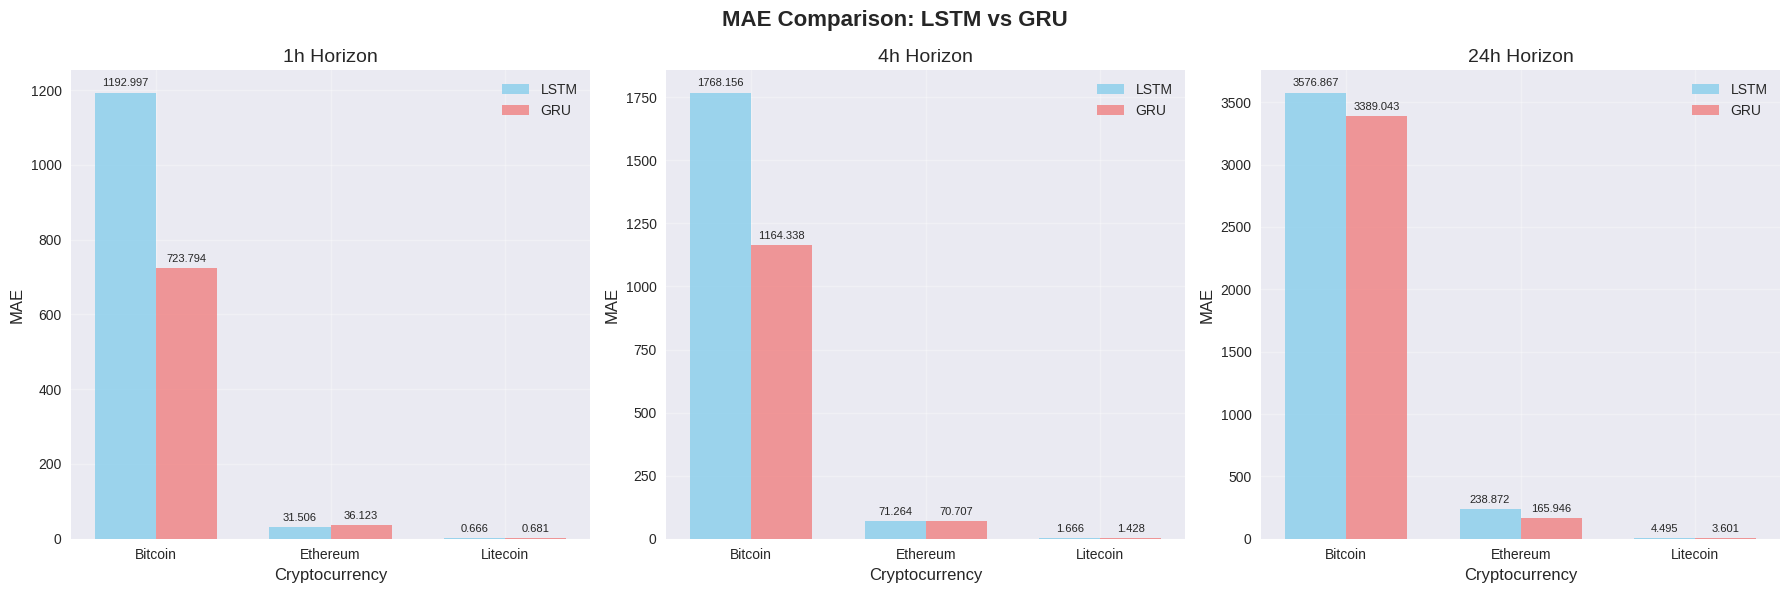

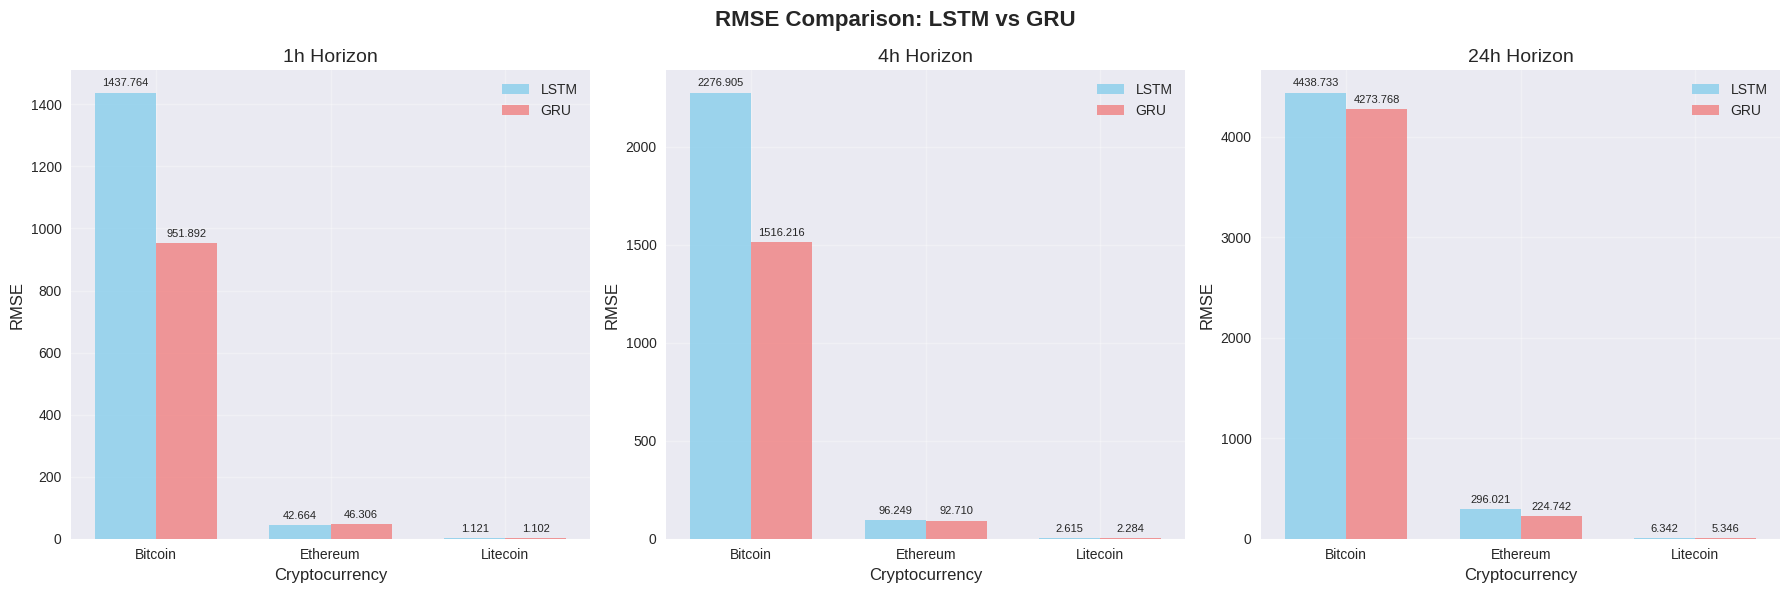

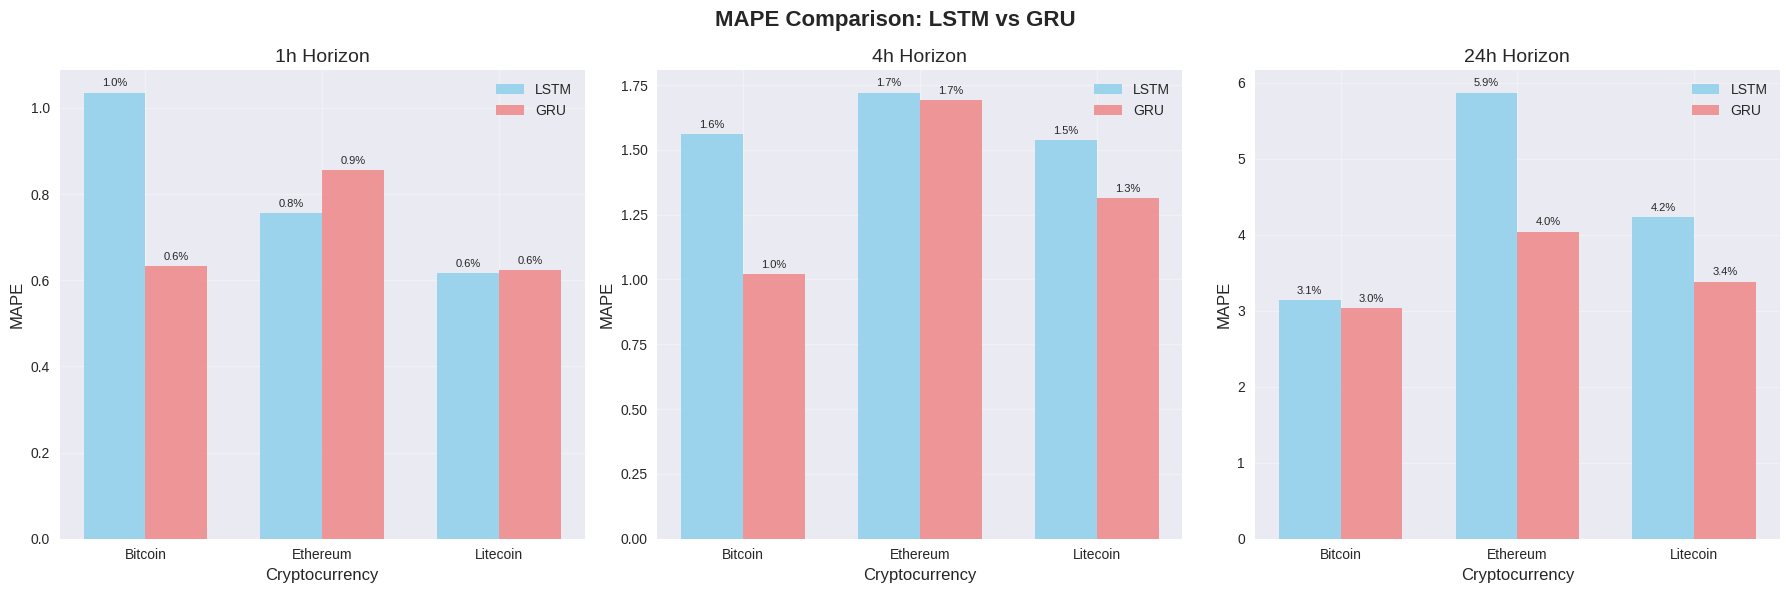

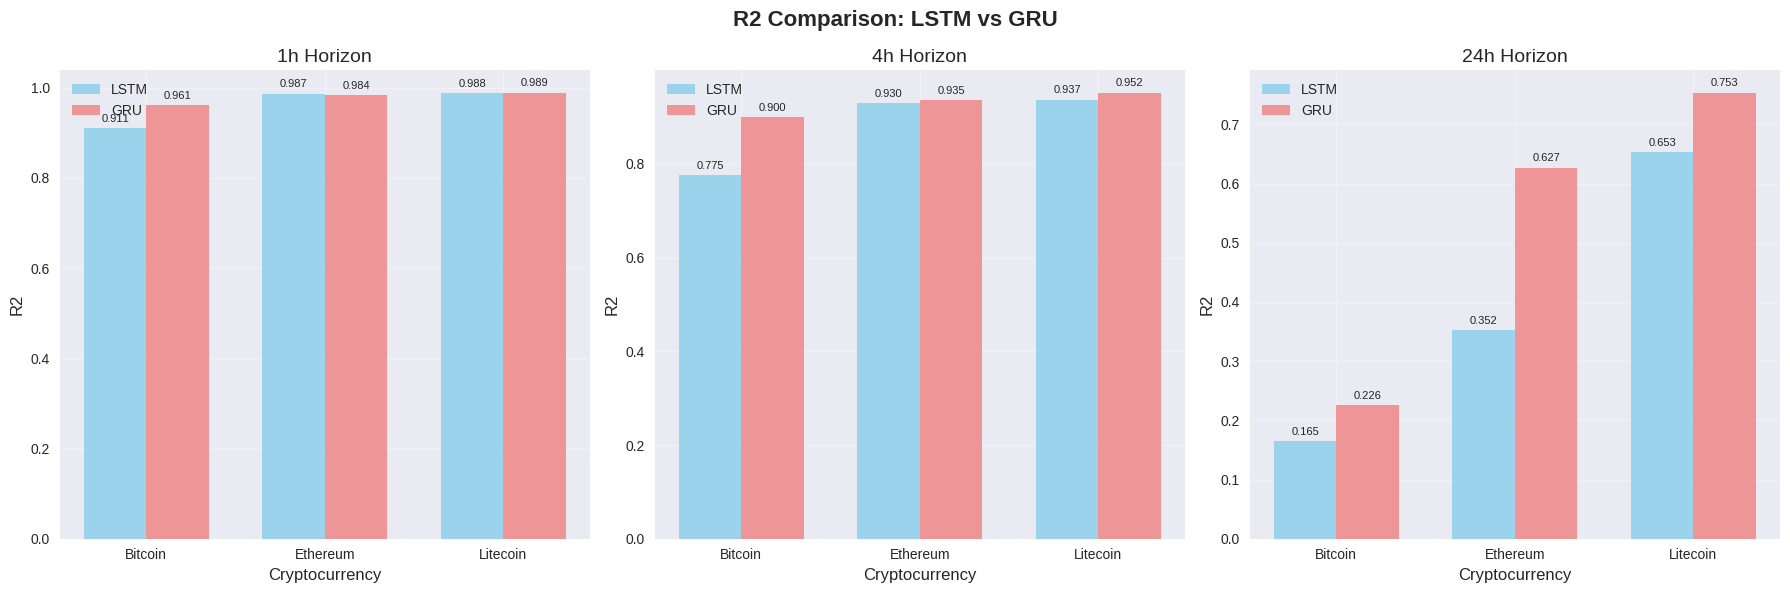

Performance comparison charts completed.


In [21]:
# 21. Performance Comparison Bar Charts (MAE, RMSE, MAPE, R2)
def create_performance_comparison_charts(lstm_results, gru_results):
    metrics = ['MAE', 'RMSE', 'MAPE', 'R2']

    for metric in metrics:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'{metric} Comparison: LSTM vs GRU', fontsize=16, fontweight='bold')

        for i, horizon in enumerate(CONFIG['forecast_horizons']):
            ax = axes[i]
            symbols = CONFIG['symbols']
            crypto_names = [name.split()[0] for name in CONFIG['crypto_names']]

            lstm_values = [lstm_results[horizon][symbol]['metrics'][metric] for symbol in symbols]
            gru_values = [gru_results[horizon][symbol]['metrics'][metric] for symbol in symbols]

            x = np.arange(len(crypto_names))
            width = 0.35

            bars1 = ax.bar(x - width/2, lstm_values, width, label='LSTM', alpha=0.8, color='skyblue')
            bars2 = ax.bar(x + width/2, gru_values, width, label='GRU', alpha=0.8, color='lightcoral')

            ax.set_title(f'{horizon}h Horizon', fontsize=14)
            ax.set_xlabel('Cryptocurrency', fontsize=12)
            ax.set_ylabel(metric, fontsize=12)
            ax.set_xticks(x)
            ax.set_xticklabels(crypto_names)
            ax.legend()
            ax.grid(True, alpha=0.3)

            def autolabel(bars, values):
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    if metric == 'MAPE':
                        label = f'{value:.1f}%'
                    elif metric in ['MAE', 'RMSE']:
                        label = f'{value:.3f}'
                    else:
                        label = f'{value:.3f}'
                    ax.annotate(label, xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3), textcoords="offset points",
                                ha='center', va='bottom', fontsize=8)

            autolabel(bars1, lstm_values)
            autolabel(bars2, gru_values)

        plt.tight_layout()
        plt.show()

print("Creating Performance Comparison Charts:")
create_performance_comparison_charts(lstm_results, gru_results)
print("Performance comparison charts completed.")



Creating Training Time Comparison:


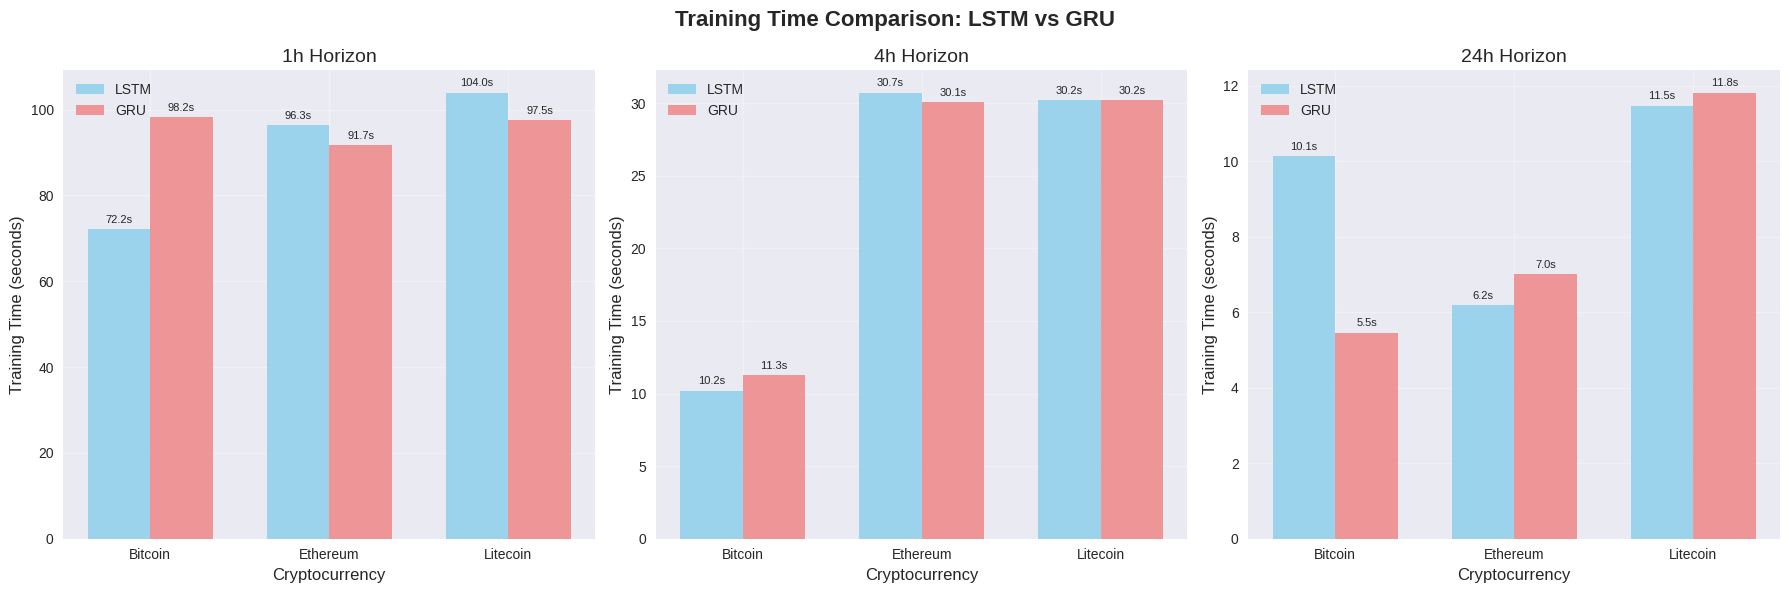


Training Time Summary:
Total LSTM training time: 371.4 seconds
Total GRU training time: 383.2 seconds
Speed ratio (LSTM/GRU): 0.97x
LSTM is 1.03x faster than GRU
Training time comparison completed.


In [22]:
# 22. Training Time Comparison
def create_training_time_comparison():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Training Time Comparison: LSTM vs GRU', fontsize=16, fontweight='bold')

    for i, horizon in enumerate(CONFIG['forecast_horizons']):
        ax = axes[i]
        symbols = CONFIG['symbols']
        crypto_names = [name.split()[0] for name in CONFIG['crypto_names']]

        lstm_times = [lstm_training_times[horizon][symbol] for symbol in symbols]
        gru_times = [gru_training_times[horizon][symbol] for symbol in symbols]

        x = np.arange(len(crypto_names))
        width = 0.35

        bars1 = ax.bar(x - width/2, lstm_times, width, label='LSTM', alpha=0.8, color='skyblue')
        bars2 = ax.bar(x + width/2, gru_times, width, label='GRU', alpha=0.8, color='lightcoral')

        ax.set_title(f'{horizon}h Horizon', fontsize=14)
        ax.set_xlabel('Cryptocurrency', fontsize=12)
        ax.set_ylabel('Training Time (seconds)', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(crypto_names)
        ax.legend()
        ax.grid(True, alpha=0.3)

        def autolabel(bars, values):
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.annotate(f'{value:.1f}s', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

        autolabel(bars1, lstm_times)
        autolabel(bars2, gru_times)

    plt.tight_layout()
    plt.show()

    print("\nTraining Time Summary:")
    print("=" * 40)

    total_lstm_time = sum(sum(lstm_training_times[h].values()) for h in CONFIG['forecast_horizons'])
    total_gru_time = sum(sum(gru_training_times[h].values()) for h in CONFIG['forecast_horizons'])

    print(f"Total LSTM training time: {total_lstm_time:.1f} seconds")
    print(f"Total GRU training time: {total_gru_time:.1f} seconds")
    print(f"Speed ratio (LSTM/GRU): {total_lstm_time/total_gru_time:.2f}x")

    if total_gru_time < total_lstm_time:
        speedup = total_lstm_time / total_gru_time
        print(f"GRU is {speedup:.2f}x faster than LSTM")
    else:
        speedup = total_gru_time / total_lstm_time
        print(f"LSTM is {speedup:.2f}x faster than GRU")

print("Creating Training Time Comparison:")
create_training_time_comparison()
print("Training time comparison completed.")


Creating Error Distribution Analysis:


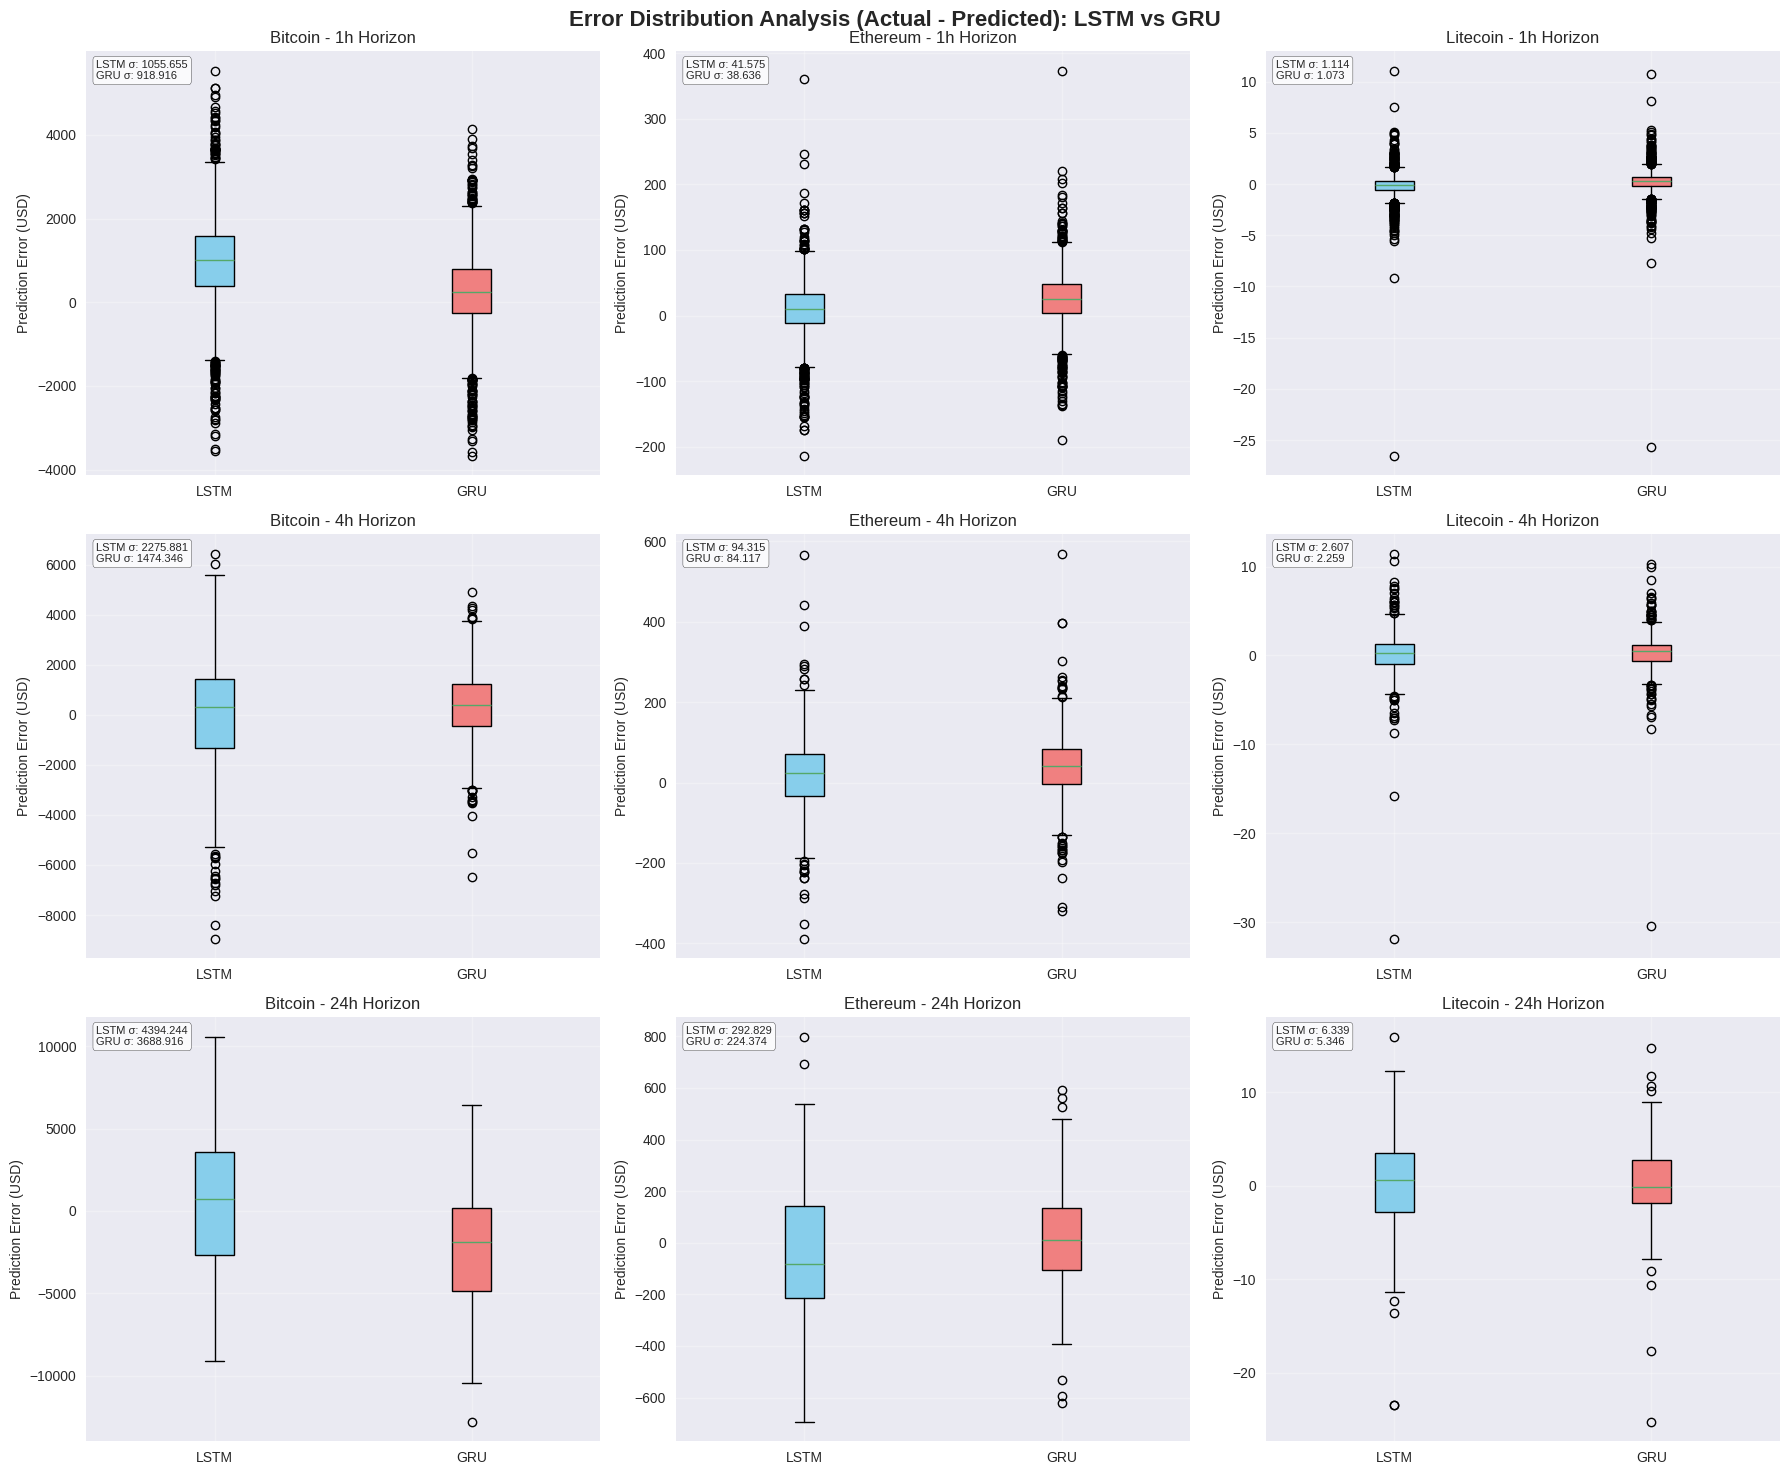

Error distribution analysis completed.


In [23]:
# 23. Error Distribution Box Plots
def create_error_distribution_plots():
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Error Distribution Analysis (Actual - Predicted): LSTM vs GRU', fontsize=16, fontweight='bold')

    for i, horizon in enumerate(CONFIG['forecast_horizons']):
        for j, symbol in enumerate(CONFIG['symbols']):
            ax = axes[i, j]

            lstm_errors = lstm_results[horizon][symbol]['y_test'] - lstm_results[horizon][symbol]['y_pred']
            gru_errors = gru_results[horizon][symbol]['y_test'] - gru_results[horizon][symbol]['y_pred']

            box_data = [lstm_errors, gru_errors]
            bp = ax.boxplot(box_data, labels=['LSTM', 'GRU'], patch_artist=True)

            bp['boxes'][0].set_facecolor('skyblue')
            bp['boxes'][1].set_facecolor('lightcoral')

            crypto_name = CONFIG['crypto_names'][j].split()[0]
            ax.set_title(f'{crypto_name} - {horizon}h Horizon', fontsize=12)
            ax.set_ylabel('Prediction Error (USD)', fontsize=10)
            ax.grid(True, alpha=0.3)

            lstm_std = np.std(lstm_errors)
            gru_std = np.std(gru_errors)
            ax.text(0.02, 0.98, f'LSTM σ: {lstm_std:.3f}\nGRU σ: {gru_std:.3f}',
                    transform=ax.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

print("Creating Error Distribution Analysis:")
create_error_distribution_plots()
print("Error distribution analysis completed.")

In [24]:
# 24. Predict Future Prices
def predict_future(model, initial_sequence, num_prediction_steps, scaler, target_column_index=3):
    current_sequence = initial_sequence.copy()
    future_predictions_scaled = []

    for _ in range(num_prediction_steps):
        prediction_input = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        predicted_scaled = model.predict(prediction_input, verbose=0)[0, 0]
        future_predictions_scaled.append(predicted_scaled)

        dummy_array = np.zeros((1, scaler.n_features_in_))
        dummy_array[0, target_column_index] = predicted_scaled
        predicted_denorm = scaler.inverse_transform(dummy_array)[0]

        next_step_features_scaled = current_sequence[-1].copy()
        next_step_features_scaled[target_column_index] = predicted_scaled

        current_sequence = np.vstack([current_sequence[1:], next_step_features_scaled])

    future_predictions_denorm = denormalize_predictions(np.array(future_predictions_scaled), scaler, target_column_index)

    return future_predictions_denorm



In [25]:
future_prediction_steps = 24

future_predictions = {}

print("Generating Future Predictions:")
print("="*60)

for horizon in CONFIG['forecast_horizons']:
    future_predictions[horizon] = {}
    print(f"\n{horizon}-hour horizon:")
    for symbol in CONFIG['symbols']:
        print(f"  Predicting future for {symbol}...")

        X_test_last_sequence = rnn_splits[horizon][symbol]['X_test'][-1]
        scaler = scalers[horizon][symbol]

        lstm_future_preds = predict_future(lstm_models[horizon][symbol], X_test_last_sequence, future_prediction_steps, scaler)

        gru_future_preds = predict_future(gru_models[horizon][symbol], X_test_last_sequence, future_prediction_steps, scaler)

        future_predictions[horizon][symbol] = {
            'lstm_preds': lstm_future_preds,
            'gru_preds': gru_future_preds
        }
        print(f"    {symbol}: Generated {future_prediction_steps} future predictions.")

print("\nFuture prediction generation completed.")


Generating Future Predictions:

1-hour horizon:
  Predicting future for BTC-USD...
    BTC-USD: Generated 24 future predictions.
  Predicting future for ETH-USD...
    ETH-USD: Generated 24 future predictions.
  Predicting future for LTC-USD...
    LTC-USD: Generated 24 future predictions.

4-hour horizon:
  Predicting future for BTC-USD...
    BTC-USD: Generated 24 future predictions.
  Predicting future for ETH-USD...
    ETH-USD: Generated 24 future predictions.
  Predicting future for LTC-USD...
    LTC-USD: Generated 24 future predictions.

24-hour horizon:
  Predicting future for BTC-USD...
    BTC-USD: Generated 24 future predictions.
  Predicting future for ETH-USD...
    ETH-USD: Generated 24 future predictions.
  Predicting future for LTC-USD...
    LTC-USD: Generated 24 future predictions.

Future prediction generation completed.


In [26]:
# 25. Visualize Future Predictions
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_future_predictions_interactive(future_predictions, lstm_results, gru_results, config, n_historical_points=200):
    horizons = config['forecast_horizons']
    symbols = config['symbols']
    crypto_names = config['crypto_names']

    for horizon in horizons:
        fig = make_subplots(rows=1, cols=len(symbols),
                            subplot_titles=[f'{name.split()[0]} - {horizon}h Horizon' for name in crypto_names])

        for j, symbol in enumerate(symbols):
            lstm_data = lstm_results[horizon][symbol]
            gru_data = gru_results[horizon][symbol]
            future_preds = future_predictions[horizon][symbol]

            historical_actual = lstm_data['y_test']
            historical_lstm_pred = lstm_data['y_pred']
            historical_gru_pred = gru_data['y_pred']

            original_data_index = resampled_data[horizon][symbol].index
            test_index_start = len(original_data_index) - len(historical_actual)
            historical_datetime_index = original_data_index[test_index_start:]

            if len(historical_actual) > n_historical_points:
                start_idx = len(historical_actual) - n_historical_points
                historical_actual_plot = historical_actual[start_idx:]
                historical_lstm_pred_plot = historical_lstm_pred[start_idx:]
                historical_gru_pred_plot = historical_gru_pred[start_idx:]
                historical_datetime_index_plot = historical_datetime_index[start_idx:]
            else:
                historical_actual_plot = historical_actual
                historical_lstm_pred_plot = historical_lstm_pred
                historical_gru_pred_plot = historical_gru_pred
                historical_datetime_index_plot = historical_datetime_index

            last_historical_time = historical_datetime_index_plot[-1]
            freq = horizon_mapping[horizon]
            future_datetime_index = pd.date_range(start=last_historical_time + pd.to_timedelta(1, unit=freq[1]), periods=len(future_preds['lstm_preds']), freq=freq)

            combined_datetime_index = historical_datetime_index_plot.union(future_datetime_index)

            fig.add_trace(go.Scatter(x=historical_datetime_index_plot, y=historical_actual_plot, mode='lines', name='Actual (Test Set)', line=dict(color='black', width=2)), row=1, col=j+1)
            fig.add_trace(go.Scatter(x=combined_datetime_index, y=np.concatenate([historical_lstm_pred_plot, future_preds['lstm_preds']]), mode='lines', name='LSTM Prediction', line=dict(color='blue', width=1.5, dash='dash')), row=1, col=j+1)
            fig.add_trace(go.Scatter(x=combined_datetime_index, y=np.concatenate([historical_gru_pred_plot, future_preds['gru_preds']]), mode='lines', name='GRU Prediction', line=dict(color='red', width=1.5, dash='dash')), row=1, col=j+1)

            fig.add_vline(x=last_historical_time, line_width=1, line_dash="dash", line_color="gray", row=1, col=j+1)


        fig.update_layout(height=600, width=1800, title_text=f'Future Price Predictions: LSTM vs GRU ({horizon}h Horizon)', showlegend=True)
        fig.show()


print("\nCreating Interactive Future Prediction Plots:")
plot_future_predictions_interactive(future_predictions, lstm_results, gru_results, CONFIG)
print("Interactive future prediction plots completed.")


Creating Interactive Future Prediction Plots:


Interactive future prediction plots completed.


### Model Performance Summary and Recommendations

Based on evaluation metrics (MAE, RMSE, MAPE, R²) and training times across 1h, 4h, and 24h forecast horizons for BTC, ETH, and LTC:

**Key Findings:**

*   **1-hour (Short-Term):** Both LSTM and GRU perform well. LSTM is slightly faster to train. GRU shows a slight edge in metrics for ETH/LTC, while LSTM is slightly better for BTC. Both are viable; **LSTM** is preferred if training speed is key, **GRU** for marginal metric gains on ETH/LTC.
*   **4-hour (Medium-Term):** GRU models consistently outperform LSTM in metrics (lower errors, higher R²). **GRU** is recommended for this horizon.
*   **24-hour (Long-Term):** Both models struggle significantly, with low R² and high errors. Predictions are less reliable. While GRU sometimes shows a slight edge, neither is highly accurate. Relying solely on these models for long-term is not advised. **GRU** is a reasonable starting point given a slight edge in metrics for ETH/LTC.
*   **Training Time:** LSTM models generally train faster than GRU models.
*   **Error Distribution:** GRU often shows a slightly tighter error distribution, but errors increase significantly for longer horizons.

**Overall Recommendation:**

*   For **1-hour** forecasts: **LSTM** (faster training) or **GRU** (slightly better metrics on some assets).
*   For **4-hour** forecasts: **GRU** (better overall metrics).
*   For **24-hour** forecasts: Both models have limited accuracy. Use as one input among others. **GRU** shows a slight metric edge.

Prediction accuracy decreases significantly with longer forecast horizons for both models.